# Word frequencies


Now that we have the abstracts in two nice neat .csv files, we need to download/import the packages needed, import the .csv files, and then can get on with the first part of the analysis. 

## Get ready 

As always, we start with a couple of code cells that load up and nickname some useful packages, then check file locations, then import files and check them. 


In [1]:
%%capture

# installing necessary pdf conversion packages via pip
# the '%%capture' at the top of this cell suppresses the output (which is normally quite long and annoying looking). 
# You can remove or comment it out if you prefer to see the output. 
!pip install nltk


In [2]:
%%capture

import os                         # os is a module for navigating your machine (e.g., file directories).
import nltk                       # nltk stands for natural language tool kit and is useful for text-mining. 
from nltk import word_tokenize    # and some of its key functions

nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.corpus import wordnet                    # Finally, things we need for lemmatising!
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer() 
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
nltk.download('averaged_perceptron_tagger')        # Like a POS-tagger...
nltk.download('wordnet')
nltk.download('webtext')
from nltk.corpus import webtext

import pandas as pd
pd.set_option('display.max_colwidth', 200)
import numpy as np
import statistics
import datetime
date = datetime.date.today()

import codecs
import csv                        # csv is for importing and working with csv files

from collections import Counter

import statistics
import re                         # things we need for RegEx corrections
import matplotlib.pyplot as plt
import string 

import math 

English_punctuation = "-!\"#$%&()'*-–+,./:;<=>?@[\]^_`{|}~''“”"      # Things for removing punctuation, stopwords and empty strings
table_punctuation = str.maketrans('','', English_punctuation)

In [ ]:
print(os.listdir("..\\output")  )                                # check 'results' folder is not empty/has correct stuff

## Import

Having checked the contents of the output folder and seen the files we expected to see, we can now import and check them. 

In [3]:
all_texts = pd.read_csv('..\\output\\all_abstracts_no_null_texts.csv')            # one for all of the texts and then
matched_texts = pd.read_csv('..\\output\\matched_abstracts_no_null_texts.csv')    # one for just those that match the keyword
expected_abstracts = pd.read_csv('..\\output\\ESHG_abstract_submissions.csv')     # one for the number of expected abstracts

In [ ]:
print (len(all_texts))                        # it is always useful to double check that the length matches your expectations
print (len(matched_texts))                    # in this case, we already know how many rows to expect in each file. 
print (len(expected_abstracts))

## Get some basic stats about how texts are spread out over time

We know that all of the rows in the files have at least two columns with contents - 'Year' and 'Text'. This means that it is probably a useful thing to get a little schematic and/or table that counts row according to year. Let's do that now!  

In [7]:
all_counts_by_year = all_texts['Year'].value_counts()         # this creates a little table with two columns - year and count
print(all_counts_by_year)                                     # however, when we print it we can see it has no headers,
                                                              # is not in order, has the years appearing as  floats, etc. 

2013.0    2373
2001.0    2336
2014.0    2240
2004.0    2205
2016.0    2040
2011.0    1967
2015.0    1951
2008.0    1896
2012.0    1871
2010.0    1716
2009.0    1704
2021.0    1570
2007.0    1541
2005.0    1520
2019.0    1437
2006.0    1422
2002.0    1266
2003.0     996
2020.0     693
2017.0     651
2018.0     584
Name: Year, dtype: int64


In [8]:
all_counts_by_year = pd.DataFrame(all_counts_by_year)                            # Convert the imported table to a data frame,
all_counts_by_year = all_counts_by_year.rename(columns={"Year": "All"})          # rename the columns,
all_counts_by_year = all_counts_by_year.rename_axis('Year').reset_index()        # set the axis to 'Year' and reset the index,
all_counts_by_year = all_counts_by_year.sort_values(by=['Year']).astype('Int64') # retype 'Year' column and sort by year.
print(all_counts_by_year)                                                        # Let's just check it worked. 

    Year   All
1   2001  2336
16  2002  1266
17  2003   996
3   2004  2205
13  2005  1520
15  2006  1422
12  2007  1541
7   2008  1896
10  2009  1704
9   2010  1716
5   2011  1967
8   2012  1871
0   2013  2373
2   2014  2240
6   2015  1951
4   2016  2040
19  2017   651
20  2018   584
14  2019  1437
18  2020   693
11  2021  1570


In [9]:
matched_counts_by_year = matched_texts['Year'].value_counts()                             # repeat for the matched_texts file
matched_counts_by_year = pd.DataFrame(matched_counts_by_year)                             # again, turn it into a data frame
matched_counts_by_year = matched_counts_by_year.rename(columns={"Year": "Matches"})       # name the columns
matched_counts_by_year = matched_counts_by_year.rename_axis('Year').reset_index()         # rename axis, reset index
matched_counts_by_year = matched_counts_by_year.sort_values(by=['Year']).astype('Int64')  # retype and sort by value of year
print(matched_counts_by_year)                                                             # and check it looks correct. 

    Year  Matches
9   2001      133
19  2002       66
20  2003       52
16  2004       89
17  2005       88
18  2006       86
15  2007       95
11  2008      122
10  2009      132
8   2010      150
6   2011      243
7   2012      224
1   2013      302
3   2014      285
0   2015      604
2   2016      293
14  2017       96
13  2018      102
4   2019      263
12  2020      111
5   2021      258


In [11]:
expected_abstracts             # This file wasn't created by our preparation processes, so we check it. 
                               # We don't need all the columns, just 'Year' and 'Total'. 
                               # Also, we can see that we don't need to retype the 'Year' or sort by 'Year' value. 

,Year,Accepted,Oral,Poster,Invited,Total
0,2001,1803,127,1676,78,1881
1,2002,1240,104,1136,36,1276
2,2003,866,60,806,32,898
3,2004,1314,115,1199,41,1355
4,2005,1384,84,1300,35,1419
5,2006,1490,195,1295,49,1539
6,2007,1395,90,1305,53,1448
7,2008,1878,129,1749,55,1933
8,2009,1562,114,1448,53,1615
9,2010,1558,147,1411,70,1628


In [12]:
expected_counts_by_year = pd.DataFrame(expected_abstracts[['Year', 'Total']])            # create data frame from just 2 columns
expected_counts_by_year = expected_counts_by_year.rename(columns = {'Total':'Expected'}) # rename 'Total' column to 'Expected'
print(expected_counts_by_year)                                                           # Let's just check it worked. 

    Year  Expected
0   2001      1881
1   2002      1276
2   2003       898
3   2004      1355
4   2005      1419
5   2006      1539
6   2007      1448
7   2008      1933
8   2009      1615
9   2010      1628
10  2011      1809
11  2012      1775
12  2013      1857
13  2014      1701
14  2015      1594
15  2016      2190
16  2017      2094
17  2018      2129
18  2019      1771
19  2020      2028
20  2021      1805
21  2022      1908
22  2023      2209


In [27]:
counts_year = all_counts_by_year.merge(matched_counts_by_year, on='Year', how='left') # now, combine the 1st two data frames
counts_year = counts_year.merge(expected_counts_by_year, on='Year', how='left')       # add the 3rd 
print(counts_year)                                                                    # and have a look at it

    Year   All  Matches  Expected
0   2001  2336      133      1881
1   2002  1266       66      1276
2   2003   996       52       898
3   2004  2205       89      1355
4   2005  1520       88      1419
5   2006  1422       86      1539
6   2007  1541       95      1448
7   2008  1896      122      1933
8   2009  1704      132      1615
9   2010  1716      150      1628
10  2011  1967      243      1809
11  2012  1871      224      1775
12  2013  2373      302      1857
13  2014  2240      285      1701
14  2015  1951      604      1594
15  2016  2040      293      2190
16  2017   651       96      2094
17  2018   584      102      2129
18  2019  1437      263      1771
19  2020   693      111      2028
20  2021  1570      258      1805


In [28]:
counts_year['Year'] = pd.to_datetime(counts_year['Year'].astype(str), format="%Y")

In [24]:
counts_year = counts_year.set_index('Year')                     # set the year as the index
print(counts_year)                                              # and have a look. Nice!

       All  Matches  Expected
Year                         
2001  2336      133      1881
2002  1266       66      1276
2003   996       52       898
2004  2205       89      1355
2005  1520       88      1419
2006  1422       86      1539
2007  1541       95      1448
2008  1896      122      1933
2009  1704      132      1615
2010  1716      150      1628
2011  1967      243      1809
2012  1871      224      1775
2013  2373      302      1857
2014  2240      285      1701
2015  1951      604      1594
2016  2040      293      2190
2017   651       96      2094
2018   584      102      2129
2019  1437      263      1771
2020   693      111      2028
2021  1570      258      1805


In [29]:
print(counts_year['All'].sum())                                # I worry too much sometimes
print(counts_year['Matches'].sum())                              # but why not check that the numbers still add up? 

33979
3794


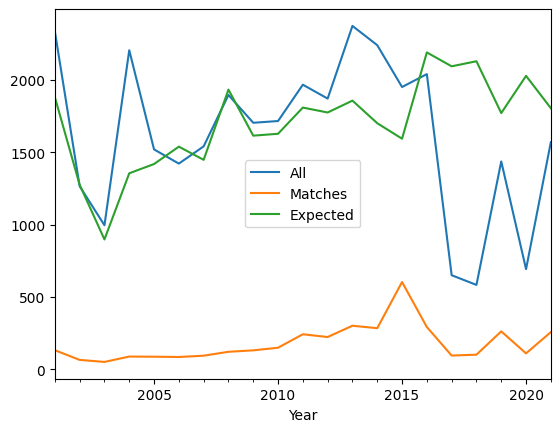

In [31]:
counts_year.plot(x='Year')                          # create a plot from the combined, re-indexed and renamed data frame
plt.show()                                          # have a look at the plot

In [ ]:
plt.savefig('..\\output\\abstract_count.jpg')    # we can right click on the plot above to save it, or save it via command

## Count word frequencies - 'bag of words'

Now that we have some basic descriptive stats about how many abstracts were imported properly with text in the 'Text' column, we can get on to the actual natural language processing steps. The most basic NLP option is to count the most frequent words found in the two sets of abstracts - meaning we need to find the most frequent words found in ALL of the abstracts and then compare that to the most frequnet words found in only those abstracts that contain a keyword of interest. 

To this end, we use the 'bag of words' method which whacks all of the words from all of the texts together, turns them into 'tokens' then processes to make them as unified as possible by removing uppercase letters, punctuation, digits, empty strings, stop words (e.g. 'the', 'and', 'for', etc. ) and word forms (e.g. pluralisations, verb endings, etc. ). 

Let's demo this with a simple example. If the text we want to 'bag of words' is "The cat named Cat was one of 5 cats." it would become a list of stemmed word-tokens like 
'''[[cat]
[name]
[cat]
[be]
[cat]]''' 
and the most common word would obviously be '''[cat]'''. 

Applying the 'bag of words' method to our texts is not so trivial, but should also be more enlightening. We would expect that the most common words from all of the texts would be similar to, but not identical to, the most common words from only the abstracts that contain a keyword of interest.

This bag of words approach ignores years, session codes, authors and everything else. Subsetting the texts by those things might be useful later. 

In [ ]:
def bag_of_words_analysis(input, how_many):     # define a 'bag of words' function with 2 arguments, an input and a quantity 
    holding_string = ""                                                        # that creates a temporary variable
    for text in input['Text']:                                                 # looks at the 'Text' column for the input
        holding_string += text                                                 # fills up the temp variable with the text
    holding_string = word_tokenize(holding_string)                             # word tokenises that text
    holding_string = [word.lower() for word in holding_string]                 # remove uppercase letters
    holding_string = [w.translate(table_punctuation) for w in holding_string]  # removes punctuation
    holding_string = (list(filter(lambda x: x, holding_string)))               # removes andy empty strings
    holding_string = [token for token in holding_string if not token.isdigit()]  # removes digits
    holding_string = [token for token in holding_string if token not in stop_words]  # removes stopwords
    holding_string = [porter.stem(token) for token in holding_string]                # stems the word-tokens
    list_for_count = []                                                              # and creates an empty list
    for token in holding_string:                                         # then iterates over the tokens
        list_for_count.append(token)                                     # appending them to the list
    counts = Counter(list_for_count)                                     # applies the Counter function imported earlier 
    return counts.most_common(how_many)                                  # and returns the tokens with highest counts 
                                                                         # up to the quantity specified as an argument

In [ ]:
most_frequent_all = bag_of_words_analysis(all_texts, 20)   # apply bag of words function to all texts, and save the output table
                                                           # this will take a while. 

In [ ]:
most_frequent_all = pd.DataFrame(most_frequent_all)                                # convert the saved output as a data frame
most_frequent_all = most_frequent_all.rename(columns={0: "Word", 1: "All count" }) # name the columns
print(most_frequent_all)                                                  # Let's just check it worked. print(most_frequent_all)

In [ ]:
most_frequent_matched = bag_of_words_analysis(matched_texts, 20) # apply the bag of words function to matched texts, and save

In [ ]:
most_frequent_matched = pd.DataFrame(most_frequent_matched)                                    # convert it to a data frame
most_frequent_matched = most_frequent_matched.rename(columns={0: "Word", 1: "Matched count" }) # name the columns
print(most_frequent_matched)                                                  # Let's just check it worked. print(most_frequent_all)

In [ ]:
most_frequent = most_frequent_all.merge(most_frequent_matched, on='Word', how='outer') # combine the two data frames via 'outer'
                                                                                       # to get the total list of all words
print(most_frequent)

In [ ]:
most_frequent.to_csv('..\\output\\most_frequent_comparison.csv')  # write out the joined most frequent words to a .csv
                                                                  # again, with a clear and useful name